In [1]:
import numpy as np
import matplotlib.pyplot as plt
import essentia
import IPython
from pylab import plot, show, figure, imshow
from essentia.standard import *
import essentia.streaming as ess

In [2]:

fnames = ['145792817.mp4', '155943863.mp4','165489427.mp4','remshit.mp4']
#audio = MonoLoader(filename='/Users/minsubsim/work/sms-tools/sounds/piano.wav')()
fname = fnames[1]
fullpath = 'samples/%s' % (fname)
sample_audio = MonoLoader(filename=fullpath)()
# Phase 1: compute the onset detection function
# The OnsetDetection algorithm provides various onset detection functions. Let's use two of them.

frameSize = 2**11
hopSize = 2**9


w = Windowing(type='blackmanharris62')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
pool = essentia.Pool()

spr_anal = SprModelAnal(fftSize = frameSize, hopSize = hopSize, maxFrequency = 50000)
spr_synth = SprModelSynth(fftSize = frameSize, hopSize = int(hopSize*1))

od1 = OnsetDetection(method='hfc')
od2 = OnsetDetection(method='complex')


In [3]:
anal_res = []

for frame in FrameGenerator(sample_audio, frameSize=frameSize, hopSize=hopSize):
    mag, phase, = c2p(fft(w(frame)))
    anal_res.append(spr_anal(frame))
    pool.add('features.hfc', od1(mag, phase))
    pool.add('features.complex', od2(mag, phase))

# Phase 2: compute the actual onsets locations
onsets = Onsets(delay=10)

onsets_hfc = onsets(# this algo expects a matrix, not a vector
                    essentia.array([ pool['features.hfc'] ]),

                    # you need to specify weights, but as there is only a single
                    # function, it doesn't actually matter which weight you give it
                    [ 1 ])

onsets_complex = onsets(essentia.array([ pool['features.complex'] ]), [ 1 ])

# Mark onsets on the audio, which we'll write back to disk
# We use beeps instead of white noise and stereo signal as it's more distinctive
onsets_hfc

array([ 1.010068 ,  2.124626 ,  2.3219955,  2.9721541,  4.237642 ,
        5.13161  ,  6.153288 ,  6.211338 ,  6.664127 ,  7.093696 ,
        7.7786846,  8.022494 ,  8.277914 ,  8.881633 ,  9.311202 ,
        9.508572 ,  9.682721 ,  9.891701 , 10.03102  , 10.25161  ,
       10.669569 , 11.099138 , 11.412608 , 11.633197 , 11.888617 ,
       12.283356 , 12.434286 , 12.678095 , 12.979955 , 13.096054 ,
       15.34839  , 16.068209 , 16.265577 , 16.451338 , 16.729977 ,
       17.194376 , 17.438187 , 17.844536 , 18.146395 , 18.227665 ,
       18.483084 , 18.831383 , 19.040363 , 19.307392 , 19.586031 ,
       19.841452 , 20.305851 , 20.65415  , 21.18821  , 21.327528 ,
       21.501678 , 21.826757 , 22.186666 , 22.453695 , 22.720726 ,
       22.871655 , 23.196735 , 23.405714 , 23.626305 , 23.858503 ,
       24.299683 , 24.659592 , 24.91501  , 25.309752 , 25.54195  ,
       25.82059  , 26.238548 , 26.5288   , 26.830658 , 26.993196 ,
       27.550476 , 27.805895 , 28.618593 , 29.024942 , 29.4893

In [4]:
loudness, ratio = BeatsLoudness(beats=onsets_hfc, beatDuration=0.01, beatWindowDuration=0.02)(sample_audio)
loud_index = sorted(range(len(onsets_hfc)), key=lambda i: loudness[i])[::-1]

num_beats = 3
beats = []
min_dist = 10.

for i in loud_index:
    if all(abs(b - onsets_hfc[i]) > min_dist for b in beats):
        print(i, loudness[i], onsets_hfc[i])
        beats.append(onsets_hfc[i])
    if len(beats) >= num_beats:
        break

beats = np.round(np.array(beats) * 44100 / hopSize)
beats

28 1.0927936 12.979955
59 0.8950387 23.858503
137 0.8263217 47.25261


array([1118., 2055., 4070.], dtype=float32)

In [5]:
print(len(anal_res), len(sample_audio))
len(sample_audio)/len(anal_res)

4659 2384896


511.8901051727839

In [20]:
onsets_f = np.round(onsets_hfc * 44100.0)
num_onsets = len(onsets_f)
onsets_f = np.append(onsets_f, len(sample_audio))

for i in range(num_onsets):
    input_audio = ess.VectorInput(sample_audio[int(onsets_f[i]):int(onsets_f[i+1])])
    framecutter = ess.FrameCutter(frameSize = frameSize, hopSize = hopSize, silentFrames='noise')
    spr_anal = ess.SprModelAnal(fftSize = frameSize, hopSize = hopSize, maxFrequency = 50000)
    spr_synth = ess.SprModelSynth(fftSize = frameSize, hopSize = int(hopSize*1))
    windowing = ess.Windowing(type='blackmanharris62')

    spectrum = ess.Spectrum()
    spectralpeaks = ess.SpectralPeaks(orderBy='magnitude',
                                      magnitudeThreshold=0.00001,
                                      minFrequency=20,
                                      maxFrequency=3500,
                                      maxPeaks=60)

    hpcp_key = ess.HPCP(size=36, # we will need higher resolution for Key estimation
                        referenceFrequency=440, # assume tuning frequency is 44100.
                        bandPreset=False,
                        minFrequency=20,
                        maxFrequency=3500,
                        weightType='cosine',
                        nonLinear=False,
                        windowSize=1.)

    keymodel = ess.Key(profileType='edma', # Use profile for electronic music
                       numHarmonics=4,
                       pcpSize=36,
                       slope=0.6,
                       usePolyphony=True,
                       useThreeChords=True)
    pool = essentia.Pool()

    
    input_audio.data >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp_key.magnitudes
    spectralpeaks.frequencies >> hpcp_key.frequencies
    hpcp_key.hpcp >> keymodel.pcp
    keymodel.key >> (pool, 'tonal.key_key')
    keymodel.scale >> (pool, 'tonal.key_scale')
    keymodel.strength >> (pool, 'tonal.key_strength')

    # Run streaming network
    essentia.run(input_audio)
    print(pool['tonal.key_key'])
    print(pool['tonal.key_scale'])
    print(pool['tonal.key_strength'])

G
major
0.5855692625045776
F#
minor
0.32895269989967346
D
major
0.3265192210674286
F
major
0.3035055100917816
E
major
0.5743395090103149
E
minor
0.6406839489936829
A#
minor
0.7565556168556213
C#
minor
0.4919581115245819
D
major
0.5254963040351868
A
minor
0.22789216041564941
G
minor
0.6820040941238403
G
major
0.31144478917121887
D#
minor
0.6658966541290283
A#
major
0.5201190114021301
F#
minor
0.6589123010635376
D
major
0.5986412763595581
D
minor
0.48955008387565613
C#
minor
0.6015368700027466
B
minor
0.397824764251709
E
major
0.44908982515335083
D
minor
0.514045774936676
G
major
0.30081814527511597
E
minor
0.6505833268165588
F#
major
0.5532588958740234
F#
major
0.7041136622428894
D#
minor
0.6751366257667542
E
minor
0.5530294179916382
C#
minor
0.5576385855674744
F
minor
0.6129277944564819
A#
major
0.4258624017238617
D
minor
0.46071499586105347
A#
major
0.46914976835250854
F#
major
0.6239689588546753
F
major
0.5565754175186157
A
major
0.5277628302574158
B
major
0.4551912546157837
D#
minor

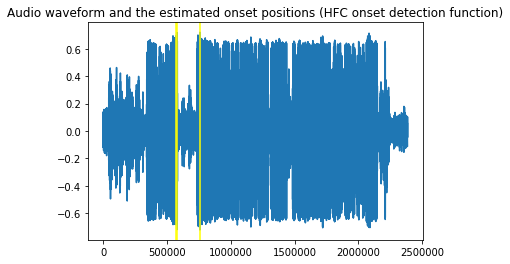

Text(0.5,1,'Audio waveform and the estimated onset positions (complex onset detection function)')

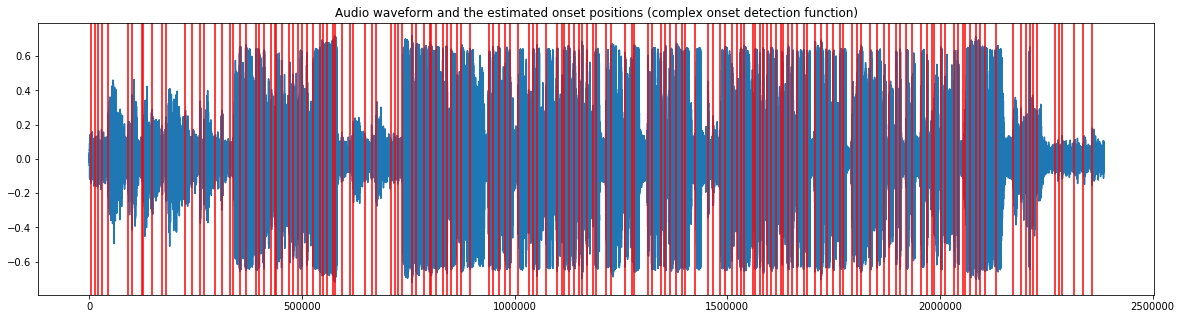

In [6]:
plot(sample_audio)
#for onset in onsets_hfc:
#    plt.axvline(x=onset*44100, color='red')
for i in loud_index[:3]:
    plt.axvline(x=onsets_hfc[i]*44100, color='yellow')

plt.title("Audio waveform and the estimated onset positions (HFC onset detection function)")
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

plot(sample_audio)
for onset in onsets_complex:
    plt.axvline(x=onset*44100, color='red')

plt.rcParams['figure.figsize'] = [20, 5]
plt.title("Audio waveform and the estimated onset positions (complex onset detection function)")

In [7]:
from mido import MidiFile

mid = MidiFile('samples/boombanng.mid')

In [8]:
import mido
print(mid.length)
print(mid.ticks_per_beat)
print(mid)

17.05087580624999
480
<midi file 'samples/boombanng.mid' type 1, 21 tracks, 191 messages>


In [9]:
inst_names = ['boom1', 'boom2', 'bang']
notes = []
tempo = None
for i, track in enumerate(mid.tracks):
    cur_time = 0
    for msg in track:
        if msg.type == 'instrument_name':
            line = inst_names.index(msg.name)
        elif msg.type == 'set_tempo':
            tempo = msg.tempo
        elif msg.type == 'note_off':
            cur_time += msg.time
        elif msg.type == 'note_on':
            cur_time += msg.time
            sec = mido.tick2second(cur_time, mid.ticks_per_beat, tempo)
            notes.append((line, sec, msg.note-60))
        #else:
        #print(msg)
notes = sorted(notes, key=lambda x: x[1])

In [10]:
import numpy as np
import cv2 as cv
video = cv.VideoCapture(fullpath)

fps = video.get(cv.CAP_PROP_FPS)
width = video.get(cv.CAP_PROP_FRAME_WIDTH)
height = video.get(cv.CAP_PROP_FRAME_HEIGHT)
print(fps, width, height)

fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output.avi', fourcc, fps, (int(width), int(height)))
frames = []
while(True):
    ret, frame = video.read()
    if not ret:
        break
    frames.append(frame)
print(len(frames))
video.release()

60.0 1920.0 1080.0
3245


In [11]:
base_audio = MonoLoader(filename='samples/dubmix.wav')()

def pitch_factor(n):
    return 2**(1.0 * n / 12.0)

for i, val in enumerate(notes):
    k, t, p = val
    start_t = int(t*44100)
    if i == len(notes)-1:
        next_t = len(base_audio)
    else:
        next_t = int(notes[i+1][1]*44100)

    beat_size = int((next_t - start_t) / hopSize)
    pf = pitch_factor(p)
    output = []
    for freq, mag, phase, resi in anal_res[int(beats[k]):int(beats[k])+beat_size]:
        out_f, out_fs, out_fr = spr_synth(mag*1.4, freq * pf, phase, resi)
        output.append(out_fs)
    clip_audio = np.asarray(output).flatten()
    clip_len = min(next_t - start_t, len(clip_audio))
    
    start_v = int(beats[k] / hopSize * fps)
    next_v = int(start_v + clip_len / 44100 * fps)
    print(start_v, next_v, len(frames))
    for f in frames[start_v:next_v]:
        out.write(f)

    base_audio[start_t:start_t+clip_len] = (base_audio[start_t:start_t+clip_len] + clip_audio[:clip_len])/2
        
MonoWriter(filename='outputs/test_dubmix.wav')(base_audio)

out.release()

131 156 3245
131 156 3245
476 501 3245
476 501 3245
131 139 3245
131 139 3245
131 139 3245
131 139 3245
131 139 3245
131 139 3245
476 480 3245
476 480 3245
476 480 3245
476 480 3245
476 480 3245
476 480 3245
476 484 3245
476 484 3245
476 484 3245
131 156 3245
131 156 3245
476 492 3245
476 496 3245
476 488 3245
131 156 3245
131 156 3245
476 501 3245
476 488 3245
476 488 3245
131 156 3245
131 156 3245
476 492 3245
476 496 3245
476 488 3245
131 156 3245
131 156 3245
476 488 3245
476 488 3245
476 488 3245
476 488 3245
131 156 3245
131 156 3245
476 492 3245
476 496 3245
476 488 3245
131 156 3245
131 156 3245
476 501 3245
476 488 3245
476 488 3245
131 156 3245
131 156 3245
476 492 3245
476 496 3245
476 488 3245
131 156 3245
131 156 3245
476 484 3245
476 484 3245
476 484 3245
476 484 3245
476 484 3245
476 484 3245


In [14]:
import IPython
IPython.display.Audio('outputs/test_dubmix.wav')

In [13]:
import subprocess
cmd = 'ffmpeg -i output.avi -i outputs/test_dubmix.wav -map 0:0 -map 1:0 -c:v copy -c:a copy result.avi'
subprocess.call(cmd, shell=True)                                     # "Muxing Done
print('Muxing Done')

Muxing Done
